In [13]:
import argparse, cPickle, pickle, os, sys, glob, scipy
import numpy as np
import healpy as hp
from skylab.priors        import SpatialPrior
from config_boxprofile    import config
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

10000


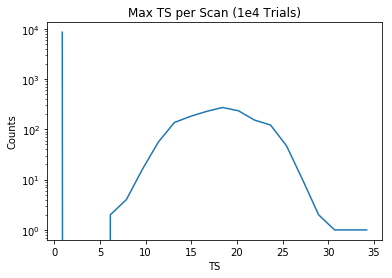

In [2]:
# Read the healpix map and return a list of probabilities for each pixel
test = np.load('GFU/output/gbm/bg_tsd/allsky_healpix_bg_tsd_54s.npy', allow_pickle=True)
max_ts = []
for i in range(len(test)):
    if test[i]['ts'].size == 0:
        max_ts.append(0.0)
    else:
        TS = np.max(test[i]['ts'])
        max_ts.append(TS)
print len(max_ts)

counts, bins = np.histogram(max_ts, bins=20)
bins = [bins[i] + (bins[i+1] - bins[i])/2 for i in range(len(bins)-1)]
plt.plot(bins, counts)
plt.yscale('log')
plt.title('Max TS per Scan (1e4 Trials)')
plt.xlabel('TS')
plt.ylabel('Counts')

In [3]:
#######################
###                 ###
###    Functions    ###
###                 ###
#######################

def compute_bg_tsd_with_prior(probs):  # Will include time window index in future
    
    no_prior_bg_tsd = np.load('GFU/output/gbm/bg_tsd/allsky_healpix_bg_tsd_54s.npy', allow_pickle=True)

    nside = hp.pixelfunc.get_nside(probs)
    if nside!=512:
        probs = hp.pixelfunc.ud_grade(probs,512,power=-2)
    
    max_ts = []
    ts_norm = np.log(np.amax(probs))
    for i in range(len(no_prior_bg_tsd)):
        # If a particular scramble in the pre-computed ts_array is empty,
        #that means that sky scan had no events in the sky, so max_ts=0
        if len(no_prior_bg_tsd[i]['ts'])==0:
            max_ts.append(0.0)
        else:
            theta, ra = hp.pix2ang(512, no_prior_bg_tsd[i]['pixel'].astype(int))  # no_prior_bg_tsd[i]['pixel'] ???
            dec = np.pi/2. - theta
            interp = hp.get_interp_val(probs,theta,ra)
            interp[interp<0] = 0.
            ts_prior = no_prior_bg_tsd[i]['ts'] + 2*(np.log(interp) - ts_norm)
            if ts_prior.max() < 0:
                max_ts.append(0.0)
            else:
                max_ts.append(ts_prior.max())

    max_ts = np.array(max_ts)

    return max_ts

def load_data(Index):
        """
        Load the bg TSD and trials dictionary.  Used to load the p-values for the time window based on the index.
        Return the bg-only TSD as a numpy array and the dictionary of trials for different neutrino injections

        Index: int
                The index of the time window.
        """

        # This is old...not sure if I'll use it again
#       with open((out_path+'pvalue_TW_{}.dict').format(Index), 'rb') as f:
#               pdict = pickle.load(f)

        tsd_path = 'GFU/output/gbm/bg_tsd/'

        # Get the bg TSD
        fname = glob.glob(tsd_path+'TW_{}_TSD/bg_trials_part*'.format(Index))
        fname.sort()

        tsd_list = []
        for f in fname:
                temp = np.load(os.path.join(f))
                tsd_list.extend(temp.tolist())
        TSD = np.concatenate([tsd_list])

        return TSD

In [4]:
probs = hp.read_map('glg_healpix_all_bn180423033_v00.fit')
tsd_with_spatial_prior = compute_bg_tsd_with_prior(probs)

Index = 0
TSD = load_data(Index)

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


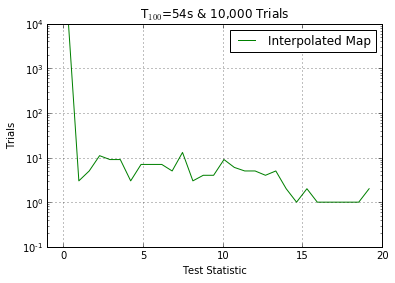

In [180]:
# Counts and Bins
counts_sp, bins_sp = np.histogram(tsd_with_spatial_prior, bins=30)
bin_centers = [bins_sp[i] + (bins_sp[i+1] - bins_sp[i])/2 for i in range(len(bins_sp)-1)]

# Plot
plt.plot(bin_centers, counts_sp, color='g', label='Interpolated Map')
plt.xlabel('Test Statistic')
plt.ylabel('Trials')
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(1e-1,1e4)
plt.title(r'T$_{100}$=54s & 10,000 Trials')
plt.legend()
plt.grid(True)

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in divide


The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map

The normal trials map scans the spatial prior map for the best TS 10,000 times


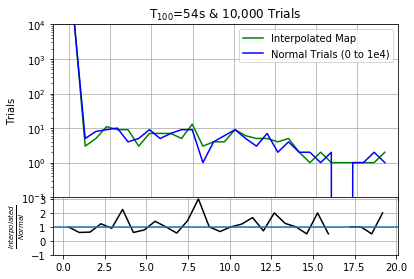

In [5]:
# Counts and Bins
counts_sp, bins_sp = np.histogram(tsd_with_spatial_prior, bins=30)
counts_no_sp1, bins_no_sp = np.histogram(TSD[:10000], bins=30)

bin_centers = [bins_sp[i] + (bins_sp[i+1] - bins_sp[i])/2 for i in range(len(bins_sp)-1)]

counts_no_sp1 = counts_no_sp1.astype(float)


# Plot
fig = plt.figure()

frame1 = fig.add_axes((0.1, 0.3, 0.8, 0.6))
plt.plot(bin_centers, counts_sp, color='g', label='Interpolated Map')
plt.plot(bin_centers, counts_no_sp1, color='b', label='Normal Trials (0 to 1e4)')
plt.xlabel('Test Statistic')
plt.ylabel('Trials')
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(1e-1,1e4)
plt.title(r'T$_{100}$=54s & 10,000 Trials')
plt.legend()
plt.grid(True)
frame1.set_xticklabels([])

frame2 = fig.add_axes((0.1, 0.1, 0.8, 0.2))


plt.plot(bin_centers, counts_sp/counts_no_sp1, color='k')
plt.yticks([-1, 0., 1., 2., 3.])
plt.grid(True)
plt.axhline(1.0)
plt.ylabel(r'$\frac{Interpolated}{Normal}$')

print "The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map\n"
print "The normal trials map scans the spatial prior map for the best TS 10,000 times"

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in divide
/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in divide


The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map

The normal trials map scans the spatial prior map for the best TS 10,000 times


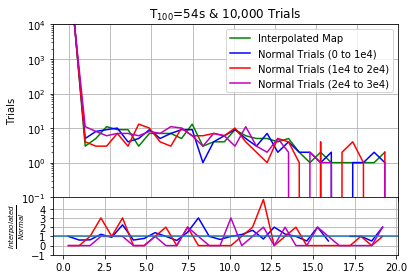

In [6]:
# Counts and Bins
counts_sp, bins_sp = np.histogram(tsd_with_spatial_prior, bins=30)
counts_no_sp1, bins_no_sp = np.histogram(TSD[:10000], bins=30)
counts_no_sp2, bins_no_sp = np.histogram(TSD[10000:20000], bins=30)
counts_no_sp3, bins_no_sp = np.histogram(TSD[20000:30000], bins=30)

bin_centers = [bins_sp[i] + (bins_sp[i+1] - bins_sp[i])/2 for i in range(len(bins_sp)-1)]

counts_no_sp1 = counts_no_sp1.astype(float)


# Plot
fig = plt.figure()

frame1 = fig.add_axes((0.1, 0.3, 0.8, 0.6))
#plt.hist(tsd_with_spatial_prior, bins=30, color='g', histtype='step', label='Interpolated Map')
#plt.hist(TSD[:10000], bins=30, histtype='step', color='b', label='Normal Trials')
#plt.hist(TSD[10000:20000], bins=30, histtype='step', color='r', label='Normal Trials')
#plt.hist(TSD[20000:30000], bins=30, histtype='step', color='m', label='Normal Trials')
plt.plot(bin_centers, counts_sp, color='g', label='Interpolated Map')
plt.plot(bin_centers, counts_no_sp1, color='b', label='Normal Trials (0 to 1e4)')
plt.plot(bin_centers, counts_no_sp2, color='r', label='Normal Trials (1e4 to 2e4)')
plt.plot(bin_centers, counts_no_sp3, color='m', label='Normal Trials (2e4 to 3e4)')
plt.xlabel('Test Statistic')
plt.ylabel('Trials')
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(1e-1,1e4)
plt.title(r'T$_{100}$=54s & 10,000 Trials')
plt.legend()
plt.grid(True)
frame1.set_xticklabels([])

frame2 = fig.add_axes((0.1, 0.1, 0.8, 0.2))


plt.plot(bin_centers, counts_sp/counts_no_sp1, color='b')
plt.plot(bin_centers, counts_sp/counts_no_sp2, color='r')
plt.plot(bin_centers, counts_sp/counts_no_sp3, color='m')
plt.yticks([-1, 0., 1., 2., 3., 4.])
plt.grid(True)
plt.axhline(1.0)
plt.ylabel(r'$\frac{Interpolated}{Normal}$')

print "The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map\n"
print "The normal trials map scans the spatial prior map for the best TS 10,000 times"

In [70]:
###
###  Now try getting p-values from each TSD for bg events, 1 ns injected, 3 ns injected, and 5 ns injected
###

# Reload the data just in case anything got messed up
probs = hp.read_map('glg_healpix_all_bn180423033_v00.fit')
tsd_with_spatial_prior = compute_bg_tsd_with_prior(probs)

Index = 0
TSD = load_data(Index)
TSD = TSD[:10000]

# Basic info
dataset = 'GFU'
season = 'IC86, 2011-2018'
time_window = 0.0

# GRB Info
time_window = (54. / 86400.)/2
t100_start = 58231.03258640          # 58130.84199171                # MJD trigger time from GRB Web 2.0
t100_stop = 58231.0332114
ra = np.radians(208.6800)       # 173.9200
dec = np.radians(9.8400)        # 23.0600

# Time Window Info

t100_center = t100_start + (t100_stop-t100_start)/2.


# Healpix stuff
spatial_prior = SpatialPrior(probs, containment=0.999, allow_neg=False)

# Create an LLH for this GRB's time and location
llh, inj = config(dataset, season, t100_center, t100_center, dec, time_window=time_window, scramble=True,
                poisson=True, spatial_prior=spatial_prior, Inj_start=t100_start, Inj_stop=t100_stop, 
                days=10, ncpu=4)

print "got llh"

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


got llh


In [71]:
# Run trials

def get_trials_and_pvals(inj, n_inj, trials):
    ts_prior = []
    for i in range(trials):
        ni, sample = inj.sample(n_inj, poisson=True)
#        if sample is not None:
#            sample['time'] = t100_center    
        val = llh.scan(ra, dec, scramble = True, seed = i, inject=sample,
            time_mask = [time_window,t100_center], pixel_scan=[512,3.0])
    
        try:
            TS = val['TS_spatial_prior_0'].max()
            ts_prior.append(TS)
            
        except ValueError:
            ts_prior.append(0.0)
    
        if i % (trials/10) == 0:
            print i
    
    return np.array(ts_prior)

In [80]:
trials_0_inj = get_trials_and_pvals(inj, 0, 10000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
10000


In [81]:
pvals_sp_0 = []
pvals_no_sp_0 = []

for k in trials_0_inj:
    p_no_sp = np.sum(TSD>=k)/float(len(TSD))
    p_sp = np.sum(tsd_with_spatial_prior>=k)/float(len(tsd_with_spatial_prior))

    if p_no_sp == 0.:
        p_no_sp = 1/float(len(TSD))
    if p_sp == 0.:
        p_sp = 1/float(len(tsd_with_spatial_prior))

    pvals_no_sp_0.append(p_no_sp)
    pvals_sp_0.append(p_sp)

print len([i for i in trials_0_inj if i>0])
print len([j for j in pvals_no_sp_0 if j<1])
print len([k for k in pvals_sp_0 if k<1])

0
0
0


In [82]:
trials_3_inj = get_trials_and_pvals(inj, 3, 100)

pvals_sp_3 = []
pvals_no_sp_3 = []

for k in trials_3_inj:
    p_no_sp = np.sum(TSD>=k)/float(len(TSD))
    p_sp = np.sum(tsd_with_spatial_prior>=k)/float(len(tsd_with_spatial_prior))

    if p_no_sp == 0.:
        p_no_sp = 1/float(len(TSD))
    if p_sp == 0.:
        p_sp = 1/float(len(tsd_with_spatial_prior))

    pvals_no_sp_3.append(p_no_sp)
    pvals_sp_3.append(p_sp)

print len([i for i in trials_3_inj if i>0])
print len([j for j in pvals_no_sp_3 if j<1])
print len([k for k in pvals_sp_3 if k<1])

0
10
20
30
40
50
60
70
80
90
10000
10000
0
0
0


In [79]:
###
###  Get some background trials for a non-GBM burst at this time and location
###

# Basic info
dataset = 'GFU'
season = 'IC86, 2011-2018'
time_window = 0.0

# GRB Info
duration = (54. / 86400.)
start = 58231.03258640          # 58130.84199171                # MJD trigger time from GRB Web 2.0
stop = 58231.0332114
ra = np.radians(208.6800)       # 173.9200
dec = np.radians(9.8400)        # 23.0600


# Create an LLH for this GRB's time and location
llh_NOT_GBM, inj_NOT_GBM = config(dataset, season, start, stop, [dec],
                rng_seed=0, time_window=0.0, Inj_start=None,
                Inj_stop=None, scramble=True, poisson=True, days=10)

print "Got LLH.  Starting trials."

tsd_not_GBM = llh_NOT_GBM.do_trials(10000, src_ra=ra, src_dec=dec, injector=inj_NOT_GBM, mean_signal=0.0)

Got LLH.  Starting trials.


In [103]:
tsd_not_GBM_3_inj = llh_NOT_GBM.do_trials(100, src_ra=ra, src_dec=dec, injector=inj_NOT_GBM, mean_signal=3.0)

In [109]:
print [i for i in tsd_not_GBM['TS'] if i>0]
print ([i for i in tsd_not_GBM_3_inj['TS'] if i>0])

[11.379223474183995, 7.628502652579319, 13.726066919580187]
94


In [105]:
pvals_sp_0 = []
pvals_no_sp_0 = []

for k in tsd_not_GBM['TS']:
    p_no_sp = np.sum(TSD>=k)/float(len(TSD))
    p_sp = np.sum(tsd_with_spatial_prior>=k)/float(len(tsd_with_spatial_prior))

    if p_no_sp == 0.:
        p_no_sp = 1/float(len(TSD))
    if p_sp == 0.:
        p_sp = 1/float(len(tsd_with_spatial_prior))

    pvals_no_sp_0.append(p_no_sp)
    pvals_sp_0.append(p_sp)
    
pvals_sp_3 = []
pvals_no_sp_3 = []

for k in tsd_not_GBM_3_inj['TS']:
    p_no_sp = np.sum(TSD>=k)/float(len(TSD))
    p_sp = np.sum(tsd_with_spatial_prior>=k)/float(len(tsd_with_spatial_prior))

    if p_no_sp == 0.:
        p_no_sp = 1/float(len(TSD))
    if p_sp == 0.:
        p_sp = 1/float(len(tsd_with_spatial_prior))

    pvals_no_sp_3.append(p_no_sp)
    pvals_sp_3.append(p_sp)

In [161]:
TS_list = np.array([i for i in tsd_not_GBM['TS'] if i>0])
TS_3_inj_no_sp = np.array(tsd_not_GBM_3_inj[np.where((np.array(pvals_no_sp_3)<1.) & (np.array(pvals_no_sp_3)>0.0001))]['TS'])
TS_3_inj_sp = np.array(tsd_not_GBM_3_inj[np.where((np.array(pvals_sp_3)<1.) & (np.array(pvals_sp_3)>0.0001))]['TS'])

condition = np.where((np.array(pvals_no_sp_3)<1.) & (np.array(pvals_no_sp_3)>0.0001))
print condition
print tsd_not_GBM_3_inj['TS'][condition]

(array([ 3, 27, 30, 44, 57, 79, 83, 84]),)
[16.24608476 11.37216617 16.8652593  18.04182536 12.33403258 16.16707899
  9.74040058 11.02904215]


In [162]:
print "\n0 injected neutrinos in the brute force trials method:\n     TS: "+str(TS_list)+"\n     p-values: "+str([i for i in pvals_no_sp_0 if i < 1])
print "\n0 injected neutrinos in the interpolated method:\n     TS: "+str(TS_list)+"\n     p-values: "+str([i for i in pvals_sp_0 if i < 1])
print "\n3 injected neutrinos in the brute force trials method:\n     TS: "+str(TS_3_inj_no_sp)+"\n     p-values: "+str([i for i in pvals_no_sp_3 if 0.0001< i < 1])
print "\n3 injected neutrinos in the interpolated method:\n     TS: "+str(TS_3_inj_sp)+"\n     p-values: "+str([i for i in pvals_sp_3 if 0.0001 < i < 1])



0 injected neutrinos in the brute force trials method:
     TS: [11.37922347  7.62850265 13.72606692]
     p-values: [0.0026, 0.0054, 0.0011]

0 injected neutrinos in the interpolated method:
     TS: [11.37922347  7.62850265 13.72606692]
     p-values: [0.0029, 0.0058, 0.0012]

3 injected neutrinos in the brute force trials method:
     TS: [16.24608476 11.37216617 16.8652593  18.04182536 12.33403258 16.16707899
  9.74040058 11.02904215]
     p-values: [0.0005, 0.0026, 0.0004, 0.0003, 0.0017, 0.0005, 0.0042, 0.0028]

3 injected neutrinos in the interpolated method:
     TS: [16.24608476 18.43360813 11.37216617 16.8652593  18.04182536 12.33403258
 16.16707899  9.74040058 11.02904215]
     p-values: [0.0006, 0.0003, 0.0029, 0.0005, 0.0003, 0.0022, 0.0007, 0.0047, 0.0031]


The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map

The normal trials map scans the spatial prior map for the best TS 10,000 times


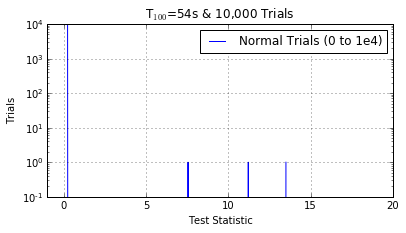

In [166]:
###
### Plot the TSD made without a spatial prior map at all (just point source)
### and compare it to a map made by grabbing the corresponding pixel from the big map
###

# Counts and Bins
counts_not_GBM, bins_not_GBM = np.histogram(tsd_not_GBM['TS'], bins=30)
#counts_one_pixel, bins_one_pixel = np.histogram(tsd_one_pixel, bins=30)

Bins = [bins_not_GBM[i] + (bins_not_GBM[i+1] - bins_not_GBM[i])/2 for i in range(len(bins_not_GBM)-1)]

counts_not_GBM = counts_not_GBM.astype(float)


# Plot
fig = plt.figure()

frame1 = fig.add_axes((0.1, 0.3, 0.8, 0.6))
#plt.plot(Bins, counts_one_pixel, color='g', label='Interpolated Map')
plt.plot(Bins, counts_not_GBM, color='b', label='Normal Trials (0 to 1e4)')
plt.xlabel('Test Statistic')
plt.ylabel('Trials')
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(1e-1,1e4)
plt.title(r'T$_{100}$=54s & 10,000 Trials')
plt.legend()
plt.grid(True)
#frame1.set_xticklabels([])

#frame2 = fig.add_axes((0.1, 0.1, 0.8, 0.2))


#plt.plot(bin_centers, counts_sp/counts_no_sp1, color='k')
#plt.yticks([-1, 0., 1., 2., 3.])
#plt.grid(True)
#plt.axhline(1.0)
#plt.ylabel(r'$\frac{Interpolated}{Normal}$')

print "The interpolated map takes the all-sky scan with no prior and interpolates with the spatial prior map\n"
print "The normal trials map scans the spatial prior map for the best TS 10,000 times"

In [179]:
import time

print "Starting LLH"
print time.ctime()
# Create an LLH for this GRB's time and location
llh_NOT_GBM, inj_NOT_GBM = config(dataset, season, start, stop, [dec],
                rng_seed=0, time_window=0.0, Inj_start=None,
                Inj_stop=None, scramble=True, poisson=True, days=10)

print "Got LLH"
print time.ctime()

print "Starting trials"
print time.ctime()

tsd_not_GBM_again = llh_NOT_GBM.do_trials(10000, src_ra=ra, src_dec=dec, injector=inj_NOT_GBM, mean_signal=0.0)

print "Got trials"
print time.ctime()

Starting LLH
Fri Jun 14 13:47:34 2019
Got LLH
Fri Jun 14 13:48:26 2019
Starting trials
Fri Jun 14 13:48:26 2019
Got trials
Fri Jun 14 16:35:31 2019


In [189]:
def get_probs_non_GBM(ra, dec):
    theta = np.pi/2. - dec
    phi = 2*np.pi - ra
    pixel = hp.ang2pix(512, theta, phi)
    probs = np.zeros(hp.nside2npix(512))
    probs[pixel] = 1.0
    return probs

def compute_bg_tsd_with_prior_non_GBM(probs):  # Will include time window index in future
    
    no_prior_bg_tsd = np.load('GFU/output/gbm/bg_tsd/allsky_healpix_bg_tsd_54s.npy', allow_pickle=True)

    max_ts = []
    ts_norm = np.log(np.amax(probs))
    for i in range(len(no_prior_bg_tsd)):
        # If a particular scramble in the pre-computed ts_array is empty,
        #that means that sky scan had no events in the sky, so max_ts=0
        if len(no_prior_bg_tsd[i]['ts'])==0:
            max_ts.append(0.0)
        else:
            theta, ra = hp.pix2ang(512, no_prior_bg_tsd[i]['pixel'].astype(int))  # no_prior_bg_tsd[i]['pixel'] ???
            dec = np.pi/2. - theta
            interp = hp.get_interp_val(probs,theta,ra)
            interp[interp<0] = 0.
            ts_prior = no_prior_bg_tsd[i]['ts'] + 2*(np.log(interp) - ts_norm)
            if ts_prior.max() < 0:
                max_ts.append(0.0)
            else:
                max_ts.append(ts_prior.max())

    max_ts = np.array(max_ts)

    return max_ts

In [190]:
probs_non_GBM = get_probs_non_GBM(ra, dec)
tsd_non_GBM_healpix = compute_bg_tsd_with_prior_non_GBM(probs_non_GBM)

/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/Ubuntu_18.04_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


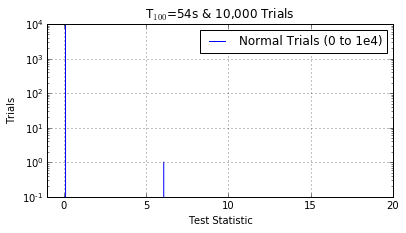

In [191]:
# Counts and Bins
counts_not_GBM, bins_not_GBM = np.histogram(tsd_non_GBM_healpix, bins=30)
#counts_one_pixel, bins_one_pixel = np.histogram(tsd_one_pixel, bins=30)

Bins = [bins_not_GBM[i] + (bins_not_GBM[i+1] - bins_not_GBM[i])/2 for i in range(len(bins_not_GBM)-1)]

counts_not_GBM = counts_not_GBM.astype(float)


# Plot
fig = plt.figure()

frame1 = fig.add_axes((0.1, 0.3, 0.8, 0.6))
#plt.plot(Bins, counts_one_pixel, color='g', label='Interpolated Map')
plt.plot(Bins, counts_not_GBM, color='b', label='Normal Trials (0 to 1e4)')
plt.xlabel('Test Statistic')
plt.ylabel('Trials')
plt.yscale('log')
plt.xlim(-1,20)
plt.ylim(1e-1,1e4)
plt.title(r'T$_{100}$=54s & 10,000 Trials')
plt.legend()
plt.grid(True)